## Setup

Carregando pacotes e funções que utilizaremos

In [1]:
from sklearn import mixture
from sklearn.model_selection import train_test_split

from dataset_functions import *
from select_vars_gmm import *

Definindo função que será utilizada para selecionar o número de componentes nos GMM}

In [2]:
def gmm_scores(X_train,X_val,k):  
    clf = mixture.GaussianMixture(n_components=k, covariance_type='full')
    clf.fit(X_train)
    return clf.score(X_val)

Carregando dois datasets que utilizaremos

In [3]:
dataset_names=['cal_housing', 'fried_delve']

In [4]:
data={}
for name in dataset_names: data[name]=download_dataset(name) 

- *** cal_housing *** dataset shape= (20640, 9)
- *** fried_delve *** dataset shape= (40769, 11)


Mantendo somente 15000 amostras

In [5]:
for name in dataset_names: 
    n = data[name].shape[0]
    index = np.random.choice(n, min(15000,n), replace=False)
    data[name]=data[name].iloc[index,:]

Dividindo datasets em X e y

In [6]:
for name in dataset_names: data[name]=get_X_y(data[name], scale=True)

## Exemplo 1: Regressão

Abrindo dataset

In [38]:
X, y = data['cal_housing']

X.shape, y.shape

((15000, 8), (15000,))

Escolhendo número de componentes do GMM

In [39]:
X_gmm_train, X_gmm_val, y_gmm_train, y_gmm_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [40]:
Z_gmm_train=np.hstack((y_gmm_train.reshape((-1,1)), X_gmm_train))
Z_gmm_val=np.hstack((y_gmm_val.reshape((-1,1)), X_gmm_val))
scores=np.array([gmm_scores(Z_gmm_train, Z_gmm_val, k) for k in list(range(1,20,1))])
k_star=np.argmax(scores)+1
k_star

19

O número ótimo de componentes é **k_star**. Fitando GMM final com k_star componentes

In [41]:
Z = np.hstack((y.reshape((-1,1)),X))
gmm = mixture.GaussianMixture(n_components=k_star, covariance_type='full')
gmm.fit(Z)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=19, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Fazendo a seleção de variáveis. O parâmetro **d_max** é o número máximo de variáveis que podemos selecionar e **stop** é o critério de parada. Por exemplo, se stop=0.01, então quando a melhora marginal de se selecionar uma variáveis é menor que 1%, em comparação ao nível passado, então o algoritmo para.

In [42]:
select=SelectVars(gmm, selection_mode = 'remove', d_max=5, stop=.01)
select.fit(X, y, verbose=True)    

Let's begin the selection...
- Round= 0 --- Î=0.76 --- Selected Features=[0, 1, 2, 3, 5, 6, 7]
- Round= 1 --- Î=0.76 --- Selected Features=[0, 1, 2, 5, 6, 7]
- Round= 2 --- Î=0.74 --- Selected Features=[0, 1, 5, 6, 7]


Das 8 variáveis originais, selecionamos 6. Vamos ver quais são essas 6:

In [43]:
select.get_vars()

[0, 1, 5, 6, 7]

Plotando informação mútua com erro padrão:

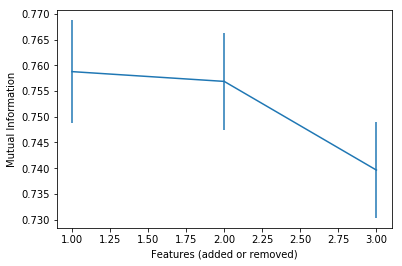

In [44]:
select.plot_mi()

Podemos ainda pegar os dados que geraram o gráfico... a tupla volta as informações mútuas e desvios-padrão

In [45]:
select.get_mi()

([0.758794252190614, 0.7568912142260318, 0.7396299457926477],
 [1.2247306189347444, 1.1528324956596974, 1.1400621357650218])

Transformando array de features (seleção)

In [46]:
X_new = select.transform(X)

X_new.shape

(15000, 5)

## Exemplo 2: Classificação

Abrindo dataset

In [7]:
X, y = data['fried_delve']

X.shape, y.shape

((15000, 10), (15000,))

Transformando label quantitativo em categórico

In [8]:
y = 1*(y>np.median(y))

Para cada classe vamos fitar um GMM. Por conta disso, criaremos um dicionário de GMMs

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
classes=list(set(y_train))
gmm={}

for c in classes:
    #Selecting number of components
    X_gmm_train, X_gmm_val, _, _=train_test_split(X_train[y_train==c], X_train[y_train==c], test_size=0.5, random_state=42)
    scores=np.array([gmm_scores(X_gmm_train, X_gmm_val, k) for k in list(range(1,15,1))])
    k_star=np.argmax(scores)+1

    #Training GMMs
    gmm[c] = mixture.GaussianMixture(n_components=k_star, covariance_type='full', random_state=42)
    gmm[c].fit(X_train[y_train==c])

Fazendo seleção. Ao contrário do caso da regressão, oferecemos ao algoritmo um dicionário de GMMs ao invés de um modelo único:

In [19]:
select=SelectVars(gmm,selection_mode='remove', d_max=3, stop=.1)
select.fit(X, y, verbose=True)    

Let's begin the selection...
- Round= 0 --- Î=0.47 --- Selected Features=[0, 1, 2, 3, 4, 5, 6, 7, 8]
- Round= 1 --- Î=0.47 --- Selected Features=[0, 1, 2, 3, 4, 6, 7, 8]
- Round= 2 --- Î=0.47 --- Selected Features=[0, 1, 2, 3, 4, 6, 8]
- Round= 3 --- Î=0.48 --- Selected Features=[0, 1, 2, 3, 4, 8]
- Round= 4 --- Î=0.48 --- Selected Features=[0, 1, 2, 3, 4]
- Round= 5 --- Î=0.42 --- Selected Features=[0, 1, 3, 4]
- Round= 6 --- Î=0.35 --- Selected Features=[0, 1, 3]


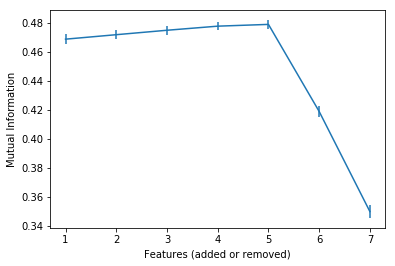

In [20]:
select.plot_mi()